A solution for titanic spaceship disastet taken from 
[spaceship-titanic-a-complete-guide](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide/notebook) A complete guide by [Samuel Cortinhas](https://www.kaggle.com/samuelcortinhas) with little modified and explained by me purely for practice

MODIFIED CHANGES:<BR>
    1) USED ONLY TRAIN DATASET TO FILL IN NULL VALUES AND AVOIDED ANY DATA LEAKAGE<BR>
    2) ADDED MORE EXLPLANATION.<BR>
    3) SOME GOOD ML PRACTICES AND DATA SPLITTING STRATEGY</BR>

# LIBRARIES

In [193]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
# from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
# import plotly.express as px
import time

# # Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# # Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

#to supress warnings
warnings.simplefilter('ignore')

# WE WILL DO THE FOLLOWING THINGS IN ORDER
- Brief overview of data and some good ml practices
- EDA
- Feature engineering
- Missing Values
- Preprocessing
- spliting into train, validation dataset
- establish a baseline model
- find the best models
- use the best models to make prediction

****EDA, Feature Engineering and Missing Values are not done sequentially as you would sometimes do EDA and feature engineering in  all the parts.****

# Data Overview and some good practices

- see some general information about the training dataset
- check for duplicates
- resample the dataset

****Overview****

In [194]:
path = Path('./files')

train_df = pd.read_csv(path / "train.csv")
test_df = pd.read_csv(path / 'test.csv')

train_df.head() # first five rows of train dataset

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [195]:
# cheking the datasets shape
rows = train_df.shape[0]
cols = train_df.shape[1]

print(f"The training dataframe has {rows} rows and {cols} cols")

The training dataframe has 8693 rows and 14 cols


In [196]:
# data types
print("TRAINING SET:\n")
display(train_df.dtypes)

print("\nTEST SET: \n")
display(test_df.dtypes)

TRAINING SET:



PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


TEST SET: 



PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

In [197]:
# missing values
print('TRAINING SET MISSING VALUES: \n')
display(train_df.isnull().sum())

print('\nTEST SET MISSING VALUES: \n')
display(test_df.isnull().sum())

TRAINING SET MISSING VALUES: 



PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


TEST SET MISSING VALUES: 



PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [198]:
total_cells = rows * cols
train_missing = train_df.isnull().sum().sum()
test_missing = test_df.isnull().sum().sum()

print(f"Missing values percentage in train set {(train_missing / total_cells) * 100}")
print(f"Missing values percentage in train set {(test_missing / total_cells) * 100}")

Missing values percentage in train set 1.9095824226389047
Missing values percentage in train set 0.917815648058372


it seems almost all rolumns have missing values. But missing values percentage is very low

<h3>Good ml prcatices<h3>

****checking for duplicates****

In [199]:
train_duplicates = train_df.duplicated(subset=['PassengerId'], keep=False)
test_duplicates = test_df.duplicated(subset=['PassengerId'], keep=False)

print(f'There are {train_duplicates.sum()} is the training dataset')
print(f'There are {test_duplicates.sum()} is the test dataset')

There are 0 is the training dataset
There are 0 is the test dataset


Good there are no duplicates

****checking cardiniality****
<br>Generally too many cardiniality(unique values) in a feature is not good for making predictions as too many unique values means less examples for each unique value. So models can not learn those few examples

In [200]:
train_df.nunique().sort_values()

CryoSleep          2
VIP                2
Transported        2
HomePlanet         3
Destination        3
Age               80
ShoppingMall    1115
RoomService     1273
VRDeck          1306
Spa             1327
FoodCourt       1507
Cabin           6560
Name            8473
PassengerId     8693
dtype: int64

<p style="color:green">Name, PasengerId and Cabin used direclty will definetly be a bad feature for the model as we only have 8700 something rows where almost same number of unique values for these features. We need to feature engineer them and make new features with more predictive power****</p>

****Resample the dataset to avoid any data skew as sometimes the dataset are in order****

You can also do this in ****spliting into train, validation dataset**** part

In [201]:
# train_df = train_df.sample(frac=1, random_state=seed) # seed for reproductivility

# EDA
* target analysis
* looking at continous categorical and gaining insight from them

****target data analysis****
* check for dataset imbalace

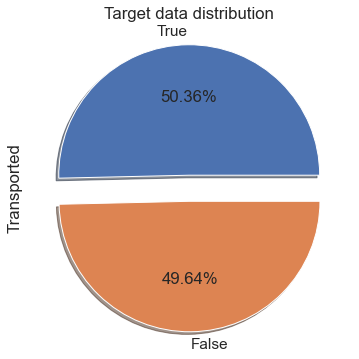

In [202]:
plt.figure(figsize=(8, 6))

train_df['Transported'].value_counts().plot(kind='pie', explode=[0.1, 0.1], 
                                            autopct='%2.2f%%', shadow=True)

plt.title('Target data distribution')
plt.show()

The target is highly balanced so we do not need to do any kind of under or oversampling

****anlayzing continious data****
- see basic overview
- look at data distribution
- look for outliers
- what kind of relation with target can we infer from the distribuion and boxplot

In [203]:
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [204]:
# declaring con_df to hold all the continous values
con_df = train_df.select_dtypes(include=['float'])
con_df.head()

Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck
0  39.0          0.0        0.0           0.0     0.0     0.0
1  24.0        109.0        9.0          25.0   549.0    44.0
2  58.0         43.0     3576.0           0.0  6715.0    49.0
3  33.0          0.0     1283.0         371.0  3329.0   193.0
4  16.0        303.0       70.0         151.0   565.0     2.0

In [205]:
con_df.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

<p>First thing that comes to my mind is that Age has normal ditribution as its mean and medain is almost same. But the min value of 0 age looks suspicious we will look into that. <br>
But all the other features looks like has great dataskew as most of the values are 0 but has a very big mean. For better representation lets plot them


<p>Since Age looks different from other we will do it separately</p>

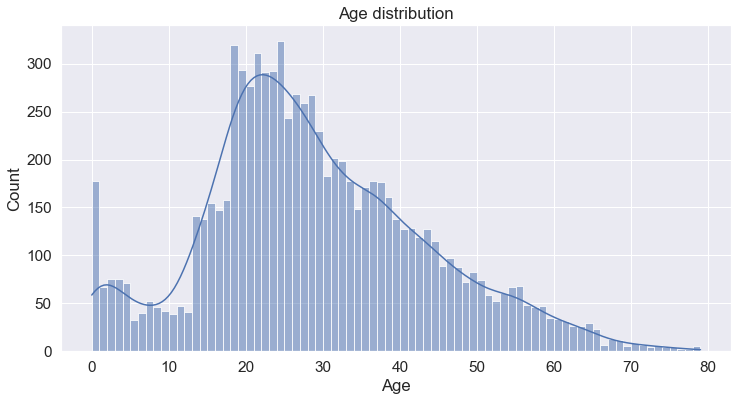

In [206]:
var = 'Age'
hue = 'Transported'

plt.figure(figsize=(12, 6))
sns.histplot(x=var, data=train_df, kde=True, binwidth=1)

plt.title("Age distribution")
plt.show()

In [207]:
print(f"Age skew: {train_df[var].skew()}") # skew
print(f"Age kurtosis: {train_df[var].kurtosis()}") # peak tendency

Age skew: 0.41909658301471536
Age kurtosis: 0.10193291871208343


Feature has fairly normal distribution and does not have much skew. But Age 0 is concerning as we do not if it means null or just new born baby lets look into that

In [208]:
con_df[con_df['Age'] == 0].head()

Age  RoomService  FoodCourt  ShoppingMall  Spa  VRDeck
19   0.0          0.0        0.0           0.0  0.0     0.0
61   0.0          0.0        0.0           0.0  0.0     0.0
86   0.0          0.0        0.0           NaN  0.0     0.0
102  0.0          0.0        0.0           0.0  0.0     0.0
157  0.0          0.0        0.0           0.0  0.0     0.0

In [209]:
# mean values of Age column
con_df[con_df['Age'] == 0].mean()

Age             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

<p>A interesting thing about this is that For Age of 0 all other luxuray expenses is 0. So having 0 age probably means newborn baby</p>

We wil plot a box plot to see a simple releation between Age and target

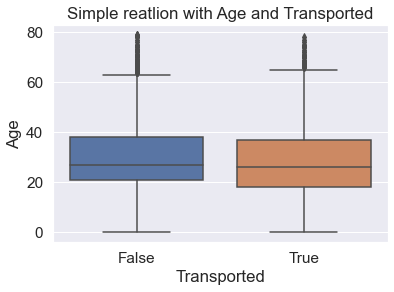

In [210]:
sns.boxplot(y='Age', x='Transported', data=train_df)

plt.title("Simple reatlion with Age and Transported")
plt.show()

****We can not see any apparent releation with target feature but sometimes we need to do much more digging to find a reatlion between features****

****Lets explore the data more with hisplot****

taking log of Age

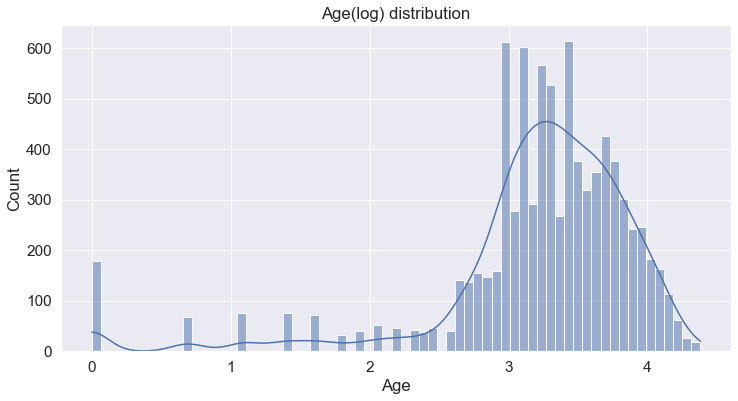

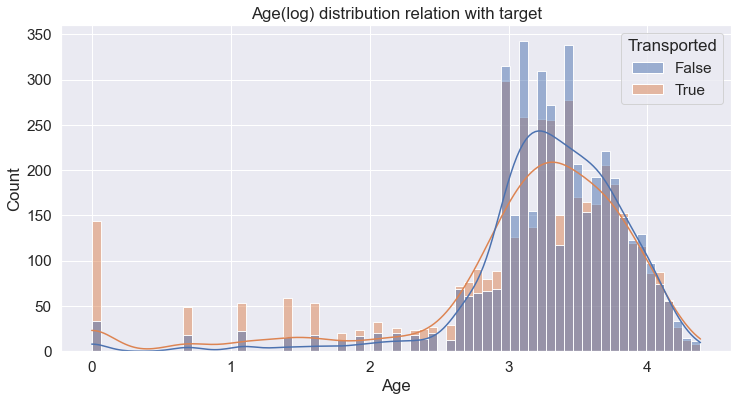

In [211]:
plt.figure(figsize=(12, 6))
sns.histplot(x=np.log(train_df[var]+1), kde=True)
plt.title("Age(log) distribution")

plt.figure(figsize=(12, 6))
sns.histplot(x=np.log(train_df[var]+1), kde=True, hue=train_df['Transported'])
plt.title("Age(log) distribution relation with target")

plt.show()

It looks very bad
* <p style="color:green">We will not do any log transformtion with the age feature as it has better predictive power without it</p>
* However when used with target feature we can see a pattern being that less aged means has more chances of being transported which we will talk about next

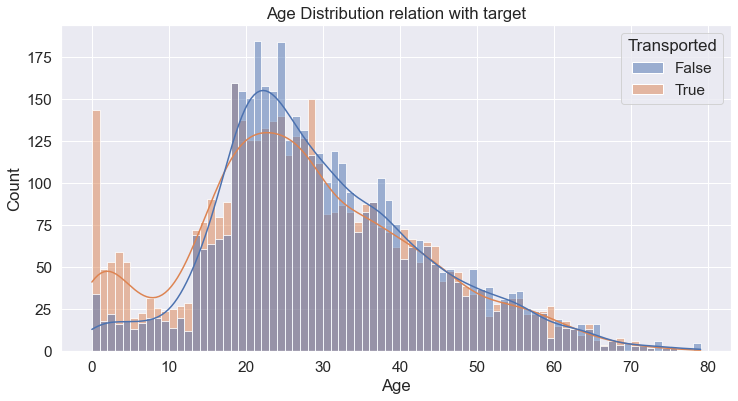

In [212]:
plt.figure(figsize=(12, 6))
sns.histplot(x=var, hue=hue, data=train_df, kde=True, binwidth=1)

plt.title('Age Distribution relation with target')
plt.show()

We can definetly tell that 
* anyone between 0 and 18 years old has much more chances of being transported 
* anyone between 18 to 28 is less likey to be transported
* over 28 years has almost equal chances of being transported

But how can we tell our model this information as number won't be able to represent them ans some model may even thinkg that less age means bad and more age means good. 


****<p style="color:green">Insight****</p>
<p style="color:green">We can try bining which converts continuous feture to categorical feature
like below<br>
- 0-18 years means belongs to one group<br>
- 18-25 belongs to other<br>
- over 26 to 30 belong another group and so on 
</p>
Feature like this would much more predictive power than previous feature in classification problem.
Although in model building we will try all the features figure out the best model while keeping the model as simple as possible

How binning would look like is plotted bellow

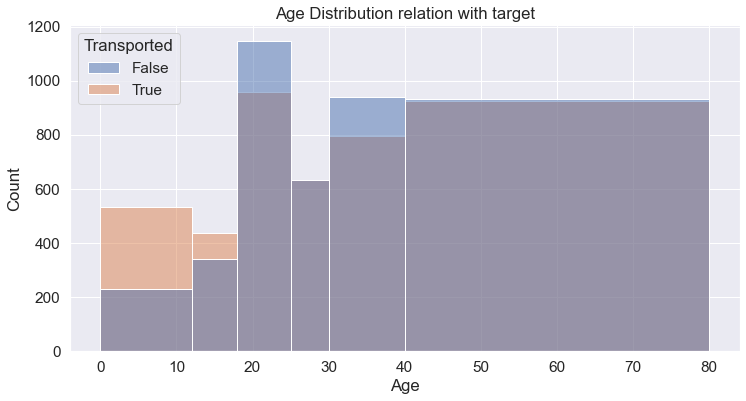

In [213]:
plt.figure(figsize=(12, 6))
sns.histplot(x=var, hue=hue, data=train_df, bins=[0, 12, 18, 25, 30, 40, 80])

plt.title('Age Distribution relation with target')
plt.show()

<p>Being less ages clearly has more chances of being transported where it is not case for other ages</p><br>Lets move on to the other continous features

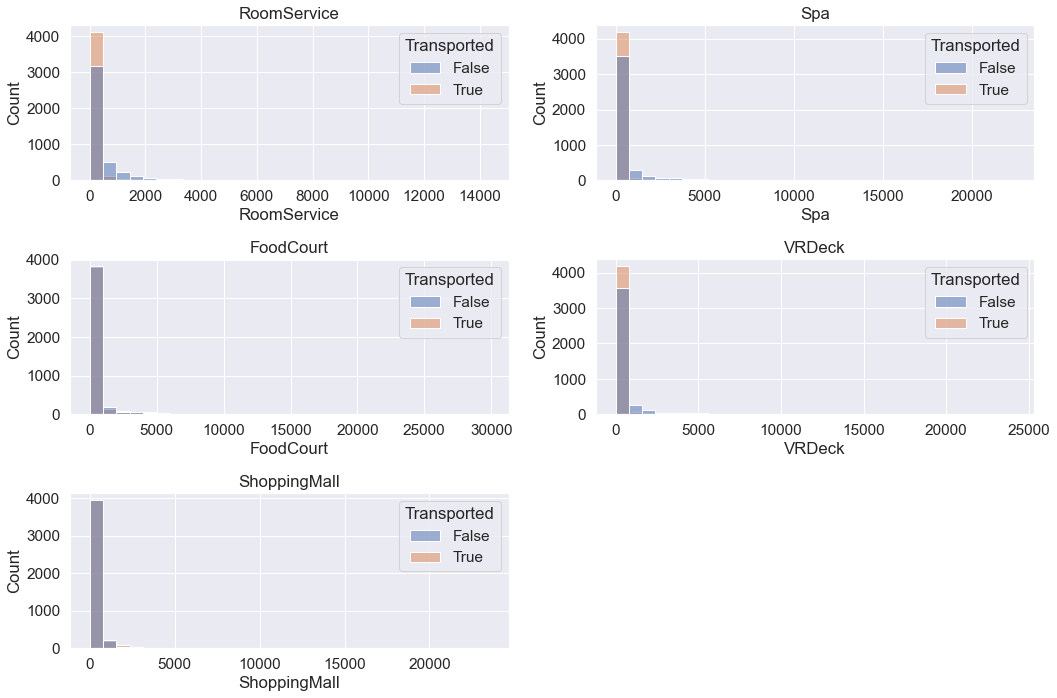

In [214]:
con_feats = list(set(con_df) - {'Age'})

fig = plt.figure(figsize=(15, 10))
for i, feature in enumerate(con_feats):
    ax = fig.add_subplot(3, 2, i+1)
    sns.histplot(data=train_df, x=feature, hue='Transported', bins=30)
    ax.set_title(feature)
    
plt.tight_layout()
plt.show()

In [215]:
# checking skewness and kurtosis
for feature in con_feats:
    print(f"{feature} skew: {train_df[feature].skew()}") # skew
    print(f"{feature} kurtosis: {train_df[feature].kurtosis()}") # peak tendency
    print()

RoomService skew: 6.333014062092135
RoomService kurtosis: 65.27380190330952

Spa skew: 7.63601988471242
Spa kurtosis: 81.20210973062822

FoodCourt skew: 7.102227852514122
FoodCourt kurtosis: 73.3072300133306

VRDeck skew: 7.819731592048683
VRDeck kurtosis: 86.01118606096058

ShoppingMall skew: 12.62756203889759
ShoppingMall kurtosis: 328.8709130625136



There are few things we can tell at a glance
  - As we have said before there are definetly data skew in all these features as we have thought before and most
    of the values are 0(most people do not spend money) and also possible outlayers
  - Common expenses places ShoppingMall and FoodCourt has different distribution and realtion with transported compared to more luxuary amenities like Spa,VRDeck and RoomService 
  - Generally spending less money on more luxuary amenities has greater chances of being transported although less luxuary amenities does not seem to have any relation with target features

To see if our assumtions are true lets zoom in a bit plt kdeplot. Normally box plot would have been more useful but since there are possible outlayers and a big skew we won't do that although it still shows the relation we searching for 

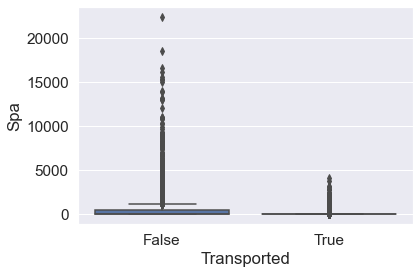

In [216]:
# box plot
sns.boxplot(x=train_df['Transported'], y=con_df['Spa'])
plt.show()

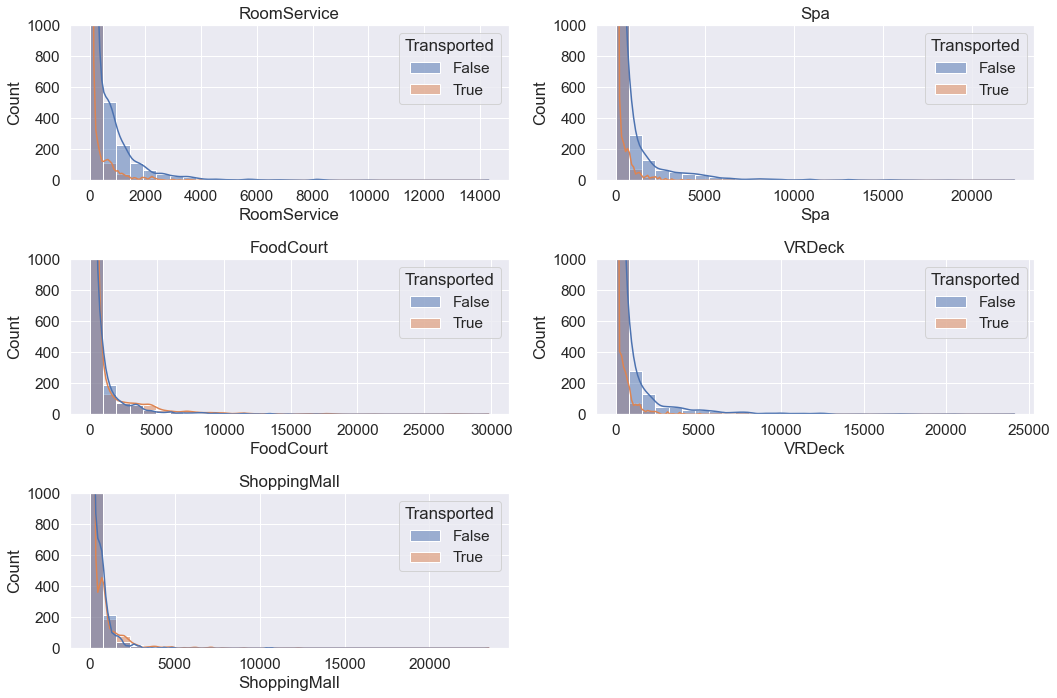

In [217]:
fig = plt.figure(figsize=(15, 10))
for i, feature in enumerate(con_feats):
    ax = fig.add_subplot(3, 2, i+1)
    sns.histplot(data=train_df, x=feature, hue='Transported', bins=30, kde=True)
    plt.ylim(0, 1000)
    ax.set_title(feature)
    
plt.tight_layout()
plt.show()

****spending less money on Spa, RoomService, VRDeck has more chances of being Transported****

****<p style="color:green">Insight:****</p>
<p style="color:green">
- Create a new feature that tracks the total expenditure across all 5 amenities<br>
- Create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).<br>
- Take the log transform to reduce skew.</p>

****analyzing categorical data****

- select categorical features
- which features has more predictive power by using countplot

In [218]:
cat_cols = list(set(train_df.columns) - set(con_df.columns))
cat_df = train_df[cat_cols]
cat_df.head()

Destination               Name CryoSleep PassengerId  Cabin    VIP  \
0  TRAPPIST-1e    Maham Ofracculy     False     0001_01  B/0/P  False   
1  TRAPPIST-1e       Juanna Vines     False     0002_01  F/0/S  False   
2  TRAPPIST-1e      Altark Susent     False     0003_01  A/0/S   True   
3  TRAPPIST-1e       Solam Susent     False     0003_02  A/0/S  False   
4  TRAPPIST-1e  Willy Santantines     False     0004_01  F/1/S  False   

  HomePlanet  Transported  
0     Europa        False  
1      Earth         True  
2     Europa        False  
3     Europa        False  
4      Earth         True

In [219]:
cat_df.nunique().sort_values().tail()

Destination       3
HomePlanet        3
Cabin          6560
Name           8473
PassengerId    8693
dtype: int64

****As we have said before because of too much cardianility we will need to fearure engineer them first before doing any analysis****

In [220]:
cat_df = cat_df.drop(columns=['Name', 'Cabin', 'PassengerId'])
cat_df.head()

Destination CryoSleep    VIP HomePlanet  Transported
0  TRAPPIST-1e     False  False     Europa        False
1  TRAPPIST-1e     False  False      Earth         True
2  TRAPPIST-1e     False   True     Europa        False
3  TRAPPIST-1e     False  False     Europa        False
4  TRAPPIST-1e     False  False      Earth         True

In [221]:
cat_df.head()

Destination CryoSleep    VIP HomePlanet  Transported
0  TRAPPIST-1e     False  False     Europa        False
1  TRAPPIST-1e     False  False      Earth         True
2  TRAPPIST-1e     False   True     Europa        False
3  TRAPPIST-1e     False  False     Europa        False
4  TRAPPIST-1e     False  False      Earth         True

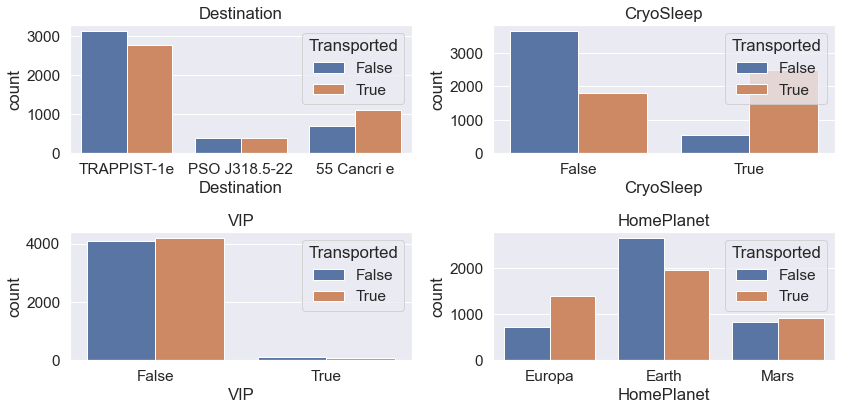

In [222]:
# plotting relation with target
fig=plt.figure(figsize=(12, 6))
for i, var_name in enumerate(cat_df.drop(columns=['Transported']).columns):
    ax=fig.add_subplot(2, 2,i+1)
    sns.countplot(data=cat_df, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
    
fig.tight_layout() 
plt.show()

VIP does not appear to be a useful feature; the target split is more or less equal.
CryoSleep appears the be a very useful feature in contrast.

****<p style='color:green'>Insights:****

<p style='color:green'>We might consider dropping the VIP column to prevent overfitting.

****Qualitative features****
* Check if you can extract useful information from them

We have already covered most of our features other than Name, PassengerId and Cabin

In [223]:
qual_feats = ['PassengerId', 'Cabin' ,'Name']
train_df[qual_feats].head()

PassengerId  Cabin               Name
0     0001_01  B/0/P    Maham Ofracculy
1     0002_01  F/0/S       Juanna Vines
2     0003_01  A/0/S      Altark Susent
3     0003_02  A/0/S       Solam Susent
4     0004_01  F/1/S  Willy Santantines

- From the data desription we know that PassengerId's first 4 values are groupnumber and last 2 digits are the member number in the group from which we can infer some useful information<br>
- Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

****<b><p style='color:green'>Insights</b></p>****
<p style='color:green'>
- We can extract the group and group size from the PassengerId feature and whether someone is alone or in group<br>
- We can extract the deck, number and side from the cabin feature.<br>
- We could extract the surname from the name feature to identify families.</p>

<b><h3>FEATURE ENGINEERING</h3></b>

****Age****<br>
Binning to age to groups

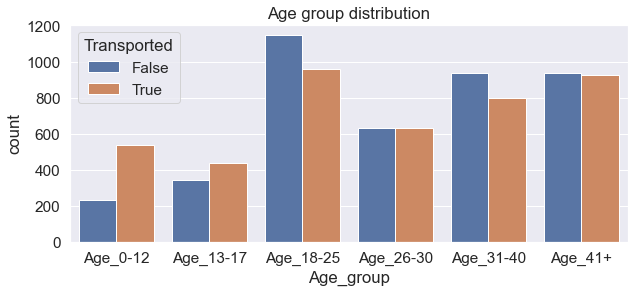

In [224]:
# train_df['Age_group'] = np.nan
# train_df.loc[train_df['Age']<=12,'Age_group']='Age_0-12'
# train_df.loc[(train_df['Age']>12) & (train_df['Age']<18),'Age_group']='Age_13-17'
# train_df.loc[(train_df['Age']>=18) & (train_df['Age']<=25),'Age_group']='Age_18-25'
# train_df.loc[(train_df['Age']>25) & (train_df['Age']<=30),'Age_group']='Age_26-30'
# train_df.loc[(train_df['Age']>30) & (train_df['Age']<=40),'Age_group']='Age_31-40'
# train_df.loc[train_df['Age']>40,'Age_group']='Age_41+'

# we can do like above but it would be time consuming so we will use pandas cut method
# test set
labels = ['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30', 'Age_31-40', 'Age_41+']
train_df['Age_group'] = pd.cut(train_df['Age'], bins=[0, 12, 18, 25, 30, 40, 80], labels=labels, right=False)


#test set
test_df['Age_group'] = pd.cut(test_df['Age'], bins=[0, 12, 18, 25, 30, 40, 80], labels=labels, right=False)


# plotting distribution
plt.figure(figsize=(10,4))
g = sns.countplot(data=train_df, x='Age_group', hue='Transported', 
                order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-40','Age_41+'])

plt.title('Age group distribution')


plt.show()

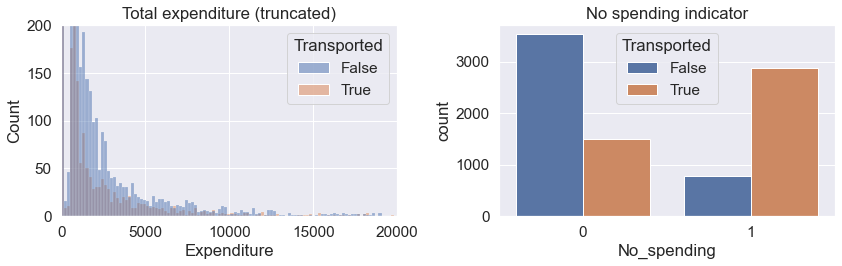

In [225]:
train_df['Expenditure'] = train_df[con_feats].sum(axis=1) # axis=1 to sum accorss columns
train_df['No_spending'] = (train_df['Expenditure'] == 0).astype(int)

test_df['Expenditure'] = test_df[con_feats].sum(axis=1)
test_df['No_spending'] = (test_df['Expenditure'] == 0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_df, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

****PassengarId****

Get group and group size 

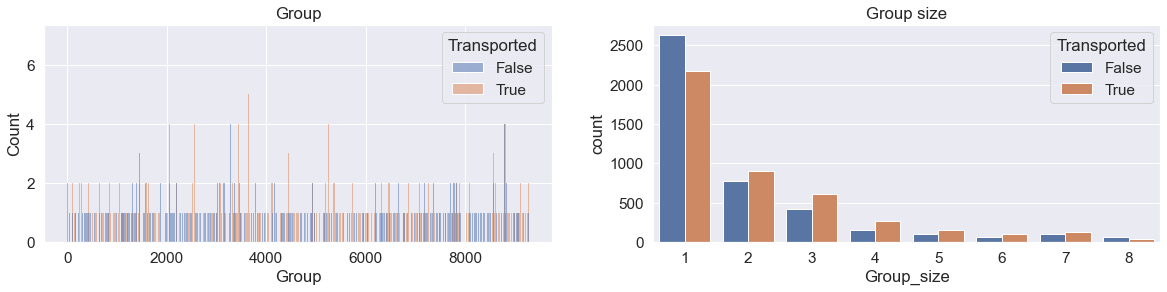

In [226]:
train_df['Group'] = train_df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_df['Group'] = test_df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# group size

group_counts = pd.concat([train_df, test_df])['Group'].value_counts()

train_df['Group_size'] = train_df['Group'].map(lambda x: group_counts[x])

test_df['Group_size'] = test_df['Group'].map(lambda x: group_counts[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train_df, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

We can't really use the Group feature in our models because it has too big of a cardinality (6217) and would explode the number of dimensions with one-hot encoding.

<p style="color:green">The Group size on the other hand should be a useful feature. In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size=1 is less likely to be transported than group size>1.</p>

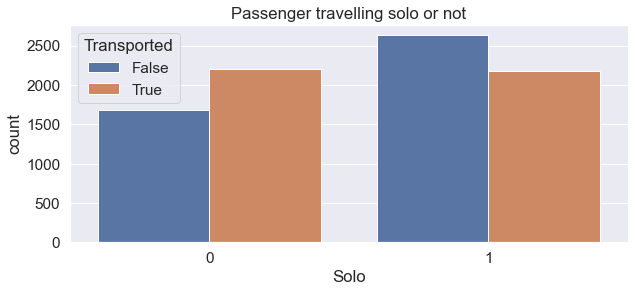

In [227]:
# New feature
train_df['Solo']= (train_df['Group_size']==1).astype(int)
test_df['Solo'] = (test_df['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train_df, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')

plt.show()

****Cabin location****

Extract deck, number and side from cabin feature.

In [228]:
train_df['Cabin'].fillna("Z/9999/Z", inplace=True)
test_df['Cabin'].fillna("Z/9999/Z", inplace=True)

# New features - training set
train_df['Cabin_deck'] = train_df['Cabin'].apply(lambda x: x.split('/')[0])
train_df['Cabin_number'] = train_df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train_df['Cabin_side'] = train_df['Cabin'].apply(lambda x: x.split('/')[2])

test_df['Cabin_deck'] = test_df['Cabin'].apply(lambda x: x.split('/')[0])
test_df['Cabin_number'] = test_df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_df['Cabin_side'] = test_df['Cabin'].apply(lambda x: x.split('/')[2])


train_df.loc[train_df['Cabin_deck'] == "Z", 'Cabin_deck'] = np.nan
train_df.loc[train_df['Cabin_number']==9999, 'Cabin_number'] = np.nan
train_df.loc[train_df['Cabin_side']=='Z', 'Cabin_side'] = np.nan
test_df.loc[test_df['Cabin_deck']=='Z', 'Cabin_deck'] = np.nan
test_df.loc[test_df['Cabin_number']==9999, 'Cabin_number'] = np.nan
test_df.loc[test_df['Cabin_side']=='Z', 'Cabin_side'] = np.nan


# Drop Cabin (we don't need it anymore)
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

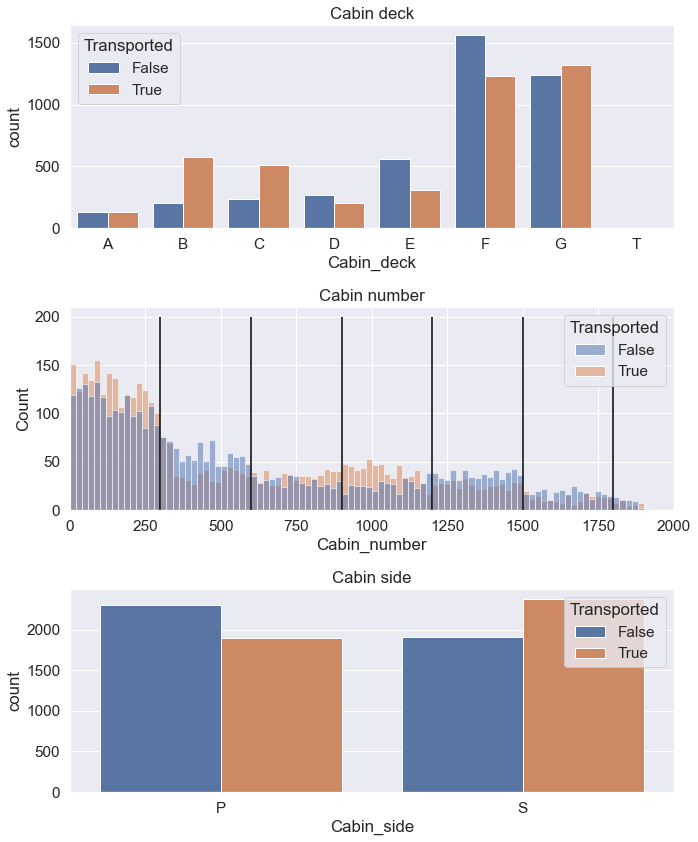

In [229]:
# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train_df, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train_df, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train_df, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

This is interesting! It appears that Cabin_number is grouped into chunks of 300 cabins. This means we can compress this feature into a categorical one, which indicates which chunk each passenger is in.

Other notes: The cabin deck 'T' seems to be an outlier (there are only 5 samples).

<p>We will one hot encode the cabin number binning because straight numbers will make the model think that 0 means bad and 7 means good. Moreover will also remove the 7 the category(greater than 1800) to avoid vanishing gradient problem

In [230]:
# New features - training set
labels = ['Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 
          'Cabin_region6', 'Cabin_region7']


train_df['Cabin_region']= pd.cut(train_df['Cabin_number'], bins=[0, 300, 600, 900, 1200, 1500, 1800, 2100], 
                             right=False, labels=labels)

# New features - test set
test_df['Cabin_region']= pd.cut(test_df['Cabin_number'], bins=[0, 300, 600, 900, 1200, 1500, 1800, 2100], 
                             right=False, labels=labels)


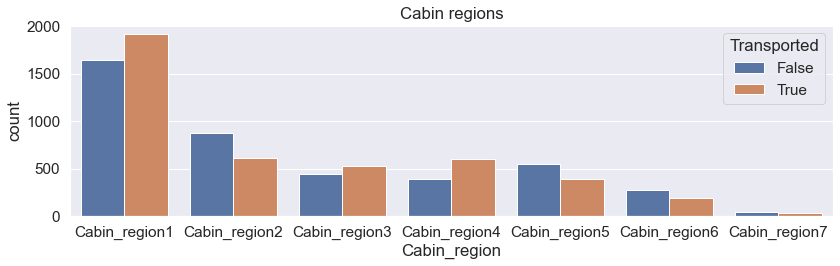

In [231]:
# Plot distribution of new features
plt.figure(figsize=(12,4))
sns.countplot(data=train_df, x='Cabin_region', hue='Transported')
plt.title('Cabin regions')
plt.tight_layout()
plt.show()

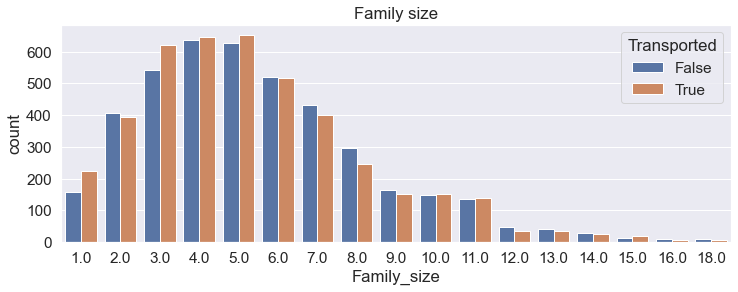

In [232]:
# filling in null values to apply map function
train_df['Name'].fillna("Unknown Unknown", inplace=True)
test_df['Name'].fillna("Unknown Unknown", inplace=True)

train_df['Surname'] = train_df['Name'].apply(lambda x: x.split()[-1])
test_df['Surname']  = test_df['Name'].apply(lambda x: x.split()[-1])

# New feature - Family size
# counting only the Surname of train only to avoid data leakage
surname_counts = train_df['Surname'].value_counts()
def family_size(x):
    try:
        return surname_counts[x]
    except:
        return surname_counts['Unknown']

train_df['Family_size'] = train_df['Surname'].map(family_size)
test_df['Family_size'] = test_df['Surname'].map(family_size)


# Put Nan's back in (we will fill these later)
train_df.loc[train_df['Surname']=='Unknown','Surname']=np.nan
train_df.loc[train_df['Family_size']>100,'Family_size']=np.nan
test_df.loc[test_df['Surname']=='Unknown','Surname']=np.nan
test_df.loc[test_df['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train_df, x='Family_size', hue='Transported')
plt.title('Family size')

plt.show()

<h3>Missing Values</h3>

* see the percentage of data we are missing in each feature
* create a heatmap to see if it is if missing values are independent
* See if number of values in feature categorazied as unknown creates a relation with taget
* see if number of missing values in an observation or row has an impact on target feature
* try different strategy to fill in missig values like join dsitribution

For now we will combine train and test as it will make it easier to work with but we will only fill in test dataset base on the values on train dataset so that data leakage occurs

In [233]:
y = train_df['Transported']
X = train_df.drop(columns=['Transported'])

data = pd.concat([X, test_df]).reset_index(drop=True)

In [234]:
X['Cabin_deck'].isnull().sum()

199

In [235]:
data['Cabin_deck'].isnull().sum()

299

<b>See percentage of missing values</b>

In [236]:
na_cols = X.columns[data.isna().any()].tolist()

mv = pd.DataFrame(X[na_cols].isnull().sum(), columns=['Missing Number'])
mv['Missing Percentage'] = np.round(mv['Missing Number']/len(X)*100, 2)
mv

Missing Number  Missing Percentage
HomePlanet               201                2.31
CryoSleep                217                2.50
Destination              182                2.09
Age                      179                2.06
VIP                      203                2.34
RoomService              181                2.08
FoodCourt                183                2.11
ShoppingMall             208                2.39
Spa                      183                2.11
VRDeck                   188                2.16
Age_group                179                2.06
Cabin_deck               199                2.29
Cabin_number             199                2.29
Cabin_side               199                2.29
Cabin_region             199                2.29
Surname                  200                2.30
Family_size              200                2.30

<b>Creating heapmap</b>

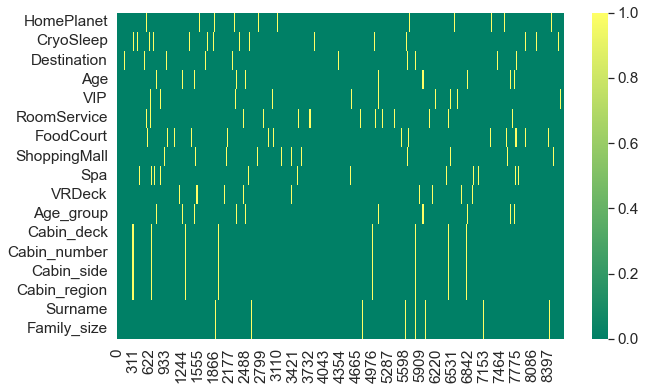

In [237]:
# for train
plt.figure(figsize=(10, 6))
sns.heatmap(X[na_cols].isna().T, cmap='summer')
plt.show()

Missing values make up about 2% of the data, which is a relatively small amount. For the most part, they don't seem to be happening at the same time (except the features made from splitting Cabin and Name), but let's inspect closer.

<b>Relationship of target and number of missing values

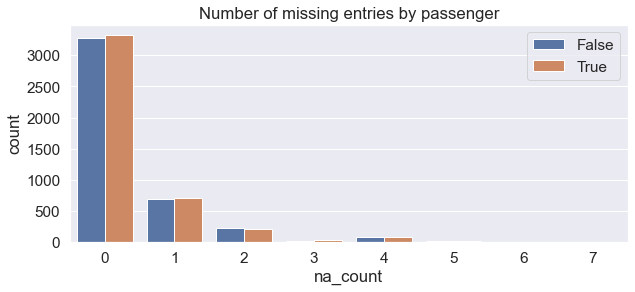

In [238]:
# Countplot of number of missing values by passenger(each row)
train_df['na_count'] = train_df.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train_df, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
plt.legend(loc='upper right')
train_df.drop('na_count', axis=1, inplace=True)

****Notes:****

- Missing values are independent of the target(the number of missing value in a row does not effect the target variable in any way) and for the most part are isolated
- Even though only 2% of the data is missing, about 25% of all passengers have at least 1 missing value.
- PassengerId is the only (original) feature to not have any missing values.

****<p style='color:green'>Insight:</p>****

<p style='color:green'>- Since most of the missing values are isolated it makes sense to try to fill these in as opposed to just dropping rows.</p>
<p style='color:green'>- If there is a relationship between PassengerId and other features we can fill missing values according to this column.</p>

****Strategy****

The easiest way to deal with missing values is to just use the median for continuous features and the mode for categorical features (see version 20 of this notebook). This will work 'well enough' but if we want to maximise the accuracy of our models then we need to look for patterns within the missing data. The way to do this is by looking at the joint distribution of features, e.g. do passengers from the same group tend to come from the same family? There are obviously many combinations so we will just summarise the useful trends I and others have found.

In doing combination it is always better to start with a feature with null values and a feature where all the values are present and there is a obvious relation between them. In our case we will start with ****Homeplanet(288 missing values)**** and ****Group(0 missing values)**** who have relation between each other.

****Homeplanet and Group****

The difference between size() and count() is that where count does not count null values size does

In [239]:
# Joint distribution of Group and HomePlanet
# we will only do it for train set and fill in the missing values using it to avoid any data lekage
GHP_gb = X.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0) # both and count can be called here
GHP_gb.head()

HomePlanet  Earth  Europa  Mars
Group                          
1             0.0     1.0   0.0
2             1.0     0.0   0.0
3             0.0     2.0   0.0
4             1.0     0.0   0.0
5             1.0     0.0   0.0

In [240]:
d = pd.DataFrame({'col': [1, 2, 2, 1, 1], 'col2': ['a', 'b', 'b', 'a', np.nan]})
d.groupby('col').count()

col2
col      
1       2
2       2

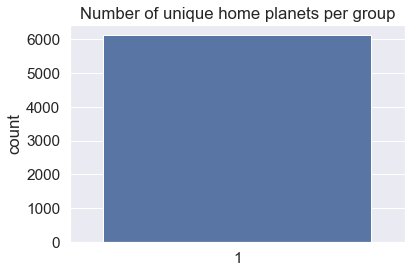

In [241]:
# Countplot of unique values
sns.countplot((GHP_gb>0).sum(axis=1))
plt.title('Number of unique home planets per group')
plt.show()

In [242]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
# filling in only based on the train set
GHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet'] = data.loc[GHP_index, :]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after in training:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after in training: 198


We managed to fill 90 values with 100% confidence but we are not finished yet.

****HomePlanet and CabinDeck****

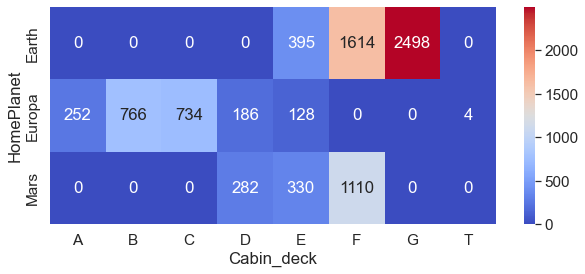

In [243]:
CDHP_gb = X.groupby(["HomePlanet", 'Cabin_deck']).size().unstack().fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb, annot=True, fmt='g', cmap='coolwarm')
plt.show()

Notes:

* Passengers on decks A, B, C or T came from Europa.
* Passengers on deck G came from Earth.
* Passengers on decks D, E or F came from multiple planets

In [244]:
# Missing values before
HP_bef = data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 198
#HomePlanet missing values after: 114


****HomePlanet and Surname****

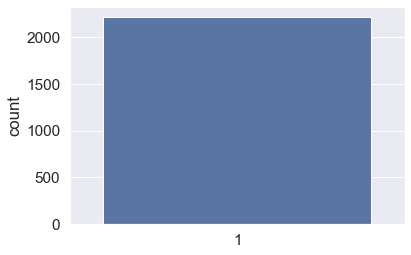

In [245]:
SHP_gb = X.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
sns.countplot((SHP_gb > 0).sum(axis=1))
plt.show()

In [246]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

SHP_index = data[data['HomePlanet'].isnull() & data['Surname'].isin(SHP_gb.index)].index

data.loc[SHP_index, 'HomePlanet']= data.loc[SHP_index, 'Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 114
#HomePlanet missing values after: 17


In [247]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

PassengerId HomePlanet  Destination
225       0242_01        NaN  TRAPPIST-1e
2274      2443_01        NaN  TRAPPIST-1e
2631      2817_01        NaN  TRAPPIST-1e
3091      3331_01        NaN  TRAPPIST-1e
4548      4840_01        NaN  TRAPPIST-1e
5252      5603_01        NaN  TRAPPIST-1e
5634      5989_01        NaN  TRAPPIST-1e
5762      6108_01        NaN  TRAPPIST-1e
8969      0616_01        NaN  TRAPPIST-1e
10097     3008_02        NaN  TRAPPIST-1e
10150     3125_02        NaN  55 Cancri e
10583     4052_01        NaN  TRAPPIST-1e
11645     6499_02        NaN  TRAPPIST-1e
11682     6559_03        NaN  TRAPPIST-1e
11913     7065_01        NaN  TRAPPIST-1e
12551     8435_01        NaN  TRAPPIST-1e
12725     8775_01        NaN  TRAPPIST-1e

Other than one instance everyone left is heading towards TRAPPIST-1e. So let's look at the joint distribution of HomePlanet and Destination.

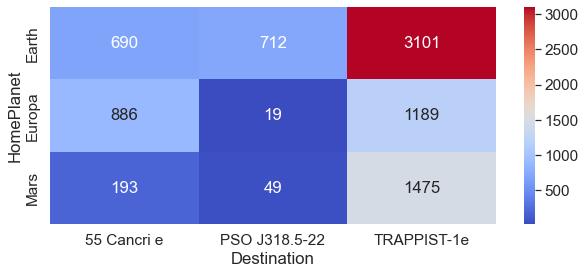

In [248]:
HPD_gb = X.groupby(['HomePlanet', 'Destination'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
sns.heatmap(HPD_gb, annot=True, cmap='coolwarm', fmt='g')
plt.show()

Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they came from there. But remember from earlier, no one on deck D came from Earth so we need to filter these out.

In [249]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['PassengerId'] == '3125_02'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'


# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 17
#HomePlanet missing values after: 0


<p>We are done with homeplanet</p>

<b>Destination</b>

Since the majority of passengers are heading towards TRAPPIST-1e (see EDA section), we'll just impute this value (i.e. the mode). A better rule hasn't been found at this stage.

In [250]:
# Missing values before
D_bef = data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


****Surname and group****

The reason we are filling missing surnames is because we will use surnames later to fill missing values of other features. It also means we can improve the accuracy of the family size feature.

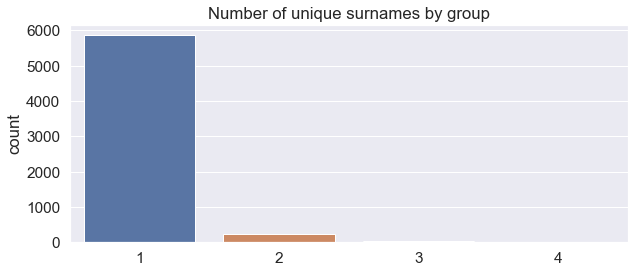

In [251]:
GSN_gb = X[X['Group_size'] > 0].groupby(['Group', 'Surname']).size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')
plt.show()

The majority of groups contain only 1 family. So let's fill missing surnames according to the majority surname in that group.

In [252]:
SN_bef=data['Surname'].isna().sum()

GSN_index = data[data['Surname'].isna() & data['Group'].isin(GSN_gb.index)].index

SN_max = GSN_gb.idxmax(axis=1)
data.loc[GSN_index, 'Surname'] = data.loc[GSN_index, 'Group'].map(lambda x: SN_max[x])


print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 198


That is the best we can do. We don't have to get rid of all of these missing values because we will end up dropping the surname feature anyway. However, we can update the family size feature.

In [253]:
data[data['PassengerId'].isin(X['PassengerId'])].shape

(8693, 23)

In [254]:
# updating X or train set
X = data[data['PassengerId'].isin(X['PassengerId'])]
X['Surname'].fillna('Unknown', inplace=True)

In [255]:
surname_counts = X['Surname'].value_counts()
def family_size(x):
    try:
        return surname_counts[x]
    except:
        return surname_counts['Unknown']

In [256]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size'] = data['Surname'].map(family_size)

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname'] = np.nan
X.loc[X['Surname'] == 'Unknown', 'Surname'] = np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

****CabinSide and Group****

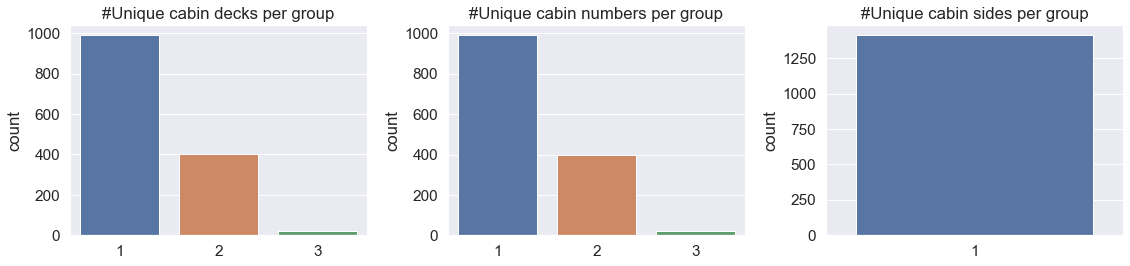

In [257]:
# Joint distribution of Group and Cabin features
GCD_gb=X[X['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=X[X['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=X[X['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('#Unique cabin sides per group')
fig.tight_layout()

<b>Another rule!</b> Everyone in the same group is also on the same cabin side. For cabin deck and cabin number there is also a fairly good (but not perfect) correlation with group.

In [258]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Cabin_side'].isna() & data['Group'].isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 199


<p>CabinSide and Surname</p>

the reason we took Group size > 1 below not family_size > 1 because if only have the same surname they may not be related as family size was inputted after after vaious transformation which also contained missing values so they may not be realted(see GSN_gb plot)but if they are in a group they will deifnetly be together

****But it does really matter much since the people with same surname came from same group most of the time****

Text(0.5, 1.0, 'Ratio of cabin side by surname')

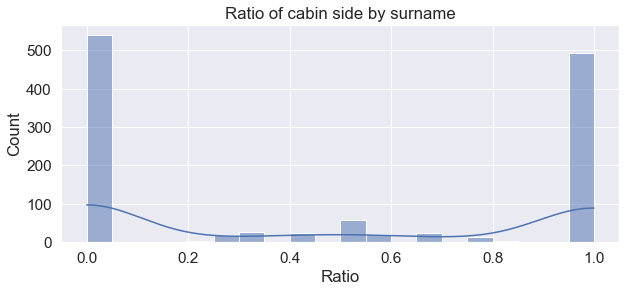

In [259]:
# Joint distribution of Surname and Cabin side
SCS_gb=X[X['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [260]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 83.6 %


Cabin_side    P    S     Ratio
Surname                       
Acobson     0.0  3.0  0.000000
Adavisons   6.0  0.0  1.000000
Admingried  0.0  4.0  0.000000
Ailled      0.0  2.0  0.000000
Ainatint    2.0  1.0  0.666667

This shows that families tend to be on the same cabin side (and 77% of families are entirely on the same side).

In [261]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values

SCS_idxmax = SCS_gb.idxmax(axis=1)
data.loc[SCS_index, 'Cabin_side'] = data.loc[SCS_index, 'Surname'].map(lambda x: SCS_idxmax[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 199
#Cabin_side missing values after: 106


The remaining missing values will be replaced with an outlier. This is because we really don't know which one of the two (balanced) sides we should assign as they did not travel with any family or group

<p style='color:red'><b>A very important step: </b>After filling in the missing values with certanity and putting remaining missing values in another group. Below cabin side Z means people whose Cabin side we do not know</p>

In [262]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 106
#Cabin_side missing values after: 0


In [263]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 199


In [264]:
# updating x
X = data[data['PassengerId'].isin(X['PassengerId'])]

In [265]:
X.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].size().fillna(0)

HomePlanet  Destination    Solo
Earth       55 Cancri e    0        270
                           1        430
            PSO J318.5-22  0        202
                           1        524
            TRAPPIST-1e    0       1094
                           1       2194
Europa      55 Cancri e    0        587
                           1        317
            PSO J318.5-22  0         10
                           1          9
            TRAPPIST-1e    0        825
                           1        426
Mars        55 Cancri e    0        100
                           1         96
            PSO J318.5-22  0         24
                           1         27
            TRAPPIST-1e    0        776
                           1        782
Name: Cabin_deck, dtype: int64

In [266]:
# Joint distribution
X.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E      F  \
HomePlanet Destination   Solo                                             
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   13.0   68.0   
                         1       0.0    0.0    0.0    0.0   34.0  205.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   13.0   42.0   
                         1       0.0    0.0    0.0    0.0   16.0  180.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0   89.0  285.0   
                         1       0.0    0.0    0.0    0.0  242.0  881.0   
Europa     55 Cancri e   0      67.0  241.0  217.0   37.0   25.0    0.0   
                         1      46.0  102.0  105.0   30.0   24.0    0.0   
           PSO J318.5-22 0       2.0    3.0    5.0    0.0    0.0    0.0   
                         1       0.0    0.0    9.0    0.0    0.0    0.0   
           TRAPPIST-1e   0     112.0  324.0  282.0   72.0   35.0    0.0   
                         1      35.0  126.0  143.0   56.0   50.0    0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   21.0   11.0   68.0   
                         1       0.0    0.0    0.0   27.0   10.0   58.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    7.0    9.0   
                         1       0.0    0.0    0.0    9.0    6.0   11.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  117.0  136.0  523.0   
                         1       0.0    0.0    0.0  110.0  174.0  480.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      189.0  0.0  
                         1      183.0  0.0  
           PSO J318.5-22 0      147.0  0.0  
                         1      316.0  0.0  
           TRAPPIST-1e   0      720.0  0.0  
                         1     1033.0  0.0  
Europa     55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  5.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

****Notes:****

* Passengers from Mars are most likely in deck F.
* Passengers from Europa are (more or less) most likely in deck C if travelling solo and deck B otherwise.
* Passengers from Earth are (more or less) most likely in deck G.

We will fill in missing values according to where the mode appears in these subgroups.

<p style="color:red">Not sure how to do it without avoiding data lekeage below</p>

In [267]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Filling in missing values using the mode
# there may be other ways to do the same thing but it can be also done like below to avoid data leakage

# getting all indexes of joint distribution and their Cabin deck column mode
HDS_group =  data.groupby(['HomePlanet','Destination','Solo'])
HDS_map = []
for index in HDS_group.size().index:
    homeplanet = index[0]
    destination = index[1]
    solo = index[2]
    cabin_deck = X[(X['HomePlanet']== homeplanet) & (X['Destination'] == destination) & (X['Solo']==solo)]['Cabin_deck'].mode()
    HDS_map.append((index, cabin_deck))

# filling in the null value according to the HomePlanet, Destination and Solo features mode Cabin deck 
for grp, mode_info in HDS_map:
    homeplanet = grp[0]
    destination = grp[1]
    solo = grp[2]
    mode = mode_info[0]
    
    null_index = data[(data['HomePlanet'] == homeplanet) & (data['Destination'] == destination) & (data['Solo'] == solo)].isnull().index
    data.loc[null_index, ['Cabin_deck']] = data.loc[null_index, ['Cabin_deck']].fillna(mode)

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 199
#Cabin_deck missing values after: 0


<b>CabinNumber and CabinDeck</b>

In [268]:
LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck'])

array([1, 5, 0, ..., 3, 3, 6])

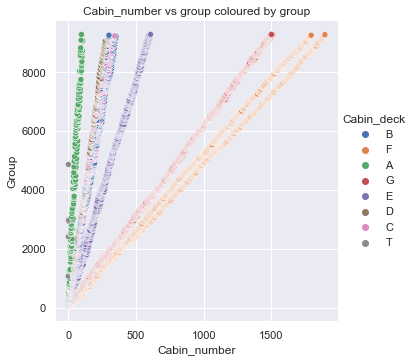

In [269]:
# Scatterplot
sns.set(rc={"figure.figsize":(10, 8)})
# sns.scatterplot(x=data['Cabin_number'], y=data['Group'],  c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']),cmap='tab10')
sns.relplot(x=X['Cabin_number'], y=X['Group'], hue=X['Cabin_deck'])
plt.title('Cabin_number vs group coloured by group')
plt.show()

There is an interesting pattern here. The cabin_number and group_number share a linear relationship on a deck by deck basis. We can therefore extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate cabin number.

In [270]:
# Missing values before
CN_bef=data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN= X.loc[~(data['Cabin_number'].isna()) & (X['Cabin_deck']==deck),'Group']
    y_CN= X.loc[~(data['Cabin_number'].isna()) & (X['Cabin_deck']==deck),'Cabin_number']
    X_test_CN = data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    print(f"The model score for deck {deck} is : {model_CN.score(X_CN.values.reshape(-1, 1), y_CN)}")
    
    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

The model score for deck A is : 0.9592748209286531
The model score for deck B is : 0.974378747104757
The model score for deck C is : 0.9773066300801688
The model score for deck D is : 0.9955628438911918
The model score for deck E is : 0.9973600816229277
The model score for deck F is : 0.994398028592463
The model score for deck G is : 0.9997751035018881
#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


Let's update the cabin regions with the new data.

In [271]:
X['Cabin_number'].max()

1894.0

<p>We need to bound the cabin number between 0 and max cabin number 1820(max value is 1820)</p>

In [272]:
def limit_cabin_number(x):
    if x < 0:
        return 0
    elif x> 1820:
        return 1820
    else:
        return x
    
data['Cabin_number'] = data['Cabin_number'].map(limit_cabin_number)

In [273]:
# New features - training set
labels = ['Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 
          'Cabin_region6', 'Cabin_region7']


data['Cabin_region']= pd.cut(data['Cabin_number'], bins=[0, 300, 600, 900, 1200, 1500, 1800, 2100], 
                             right=False, labels=labels)

In [274]:
# updating x
X = data[data['PassengerId'].isin(X['PassengerId'])]

In [275]:
# One-hot encode cabin regions
# data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
# data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
# data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
# data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
# data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
# data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
# data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

****VIP****

VIP is a highly unbalanced binary feature so we will just impute the mode.

In [276]:
X['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [277]:
# Missing values before
V_bef= data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP'] = False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


****Age****

Age varies across many features like HomePlanet, group size, expenditure and cabin deck, so we will impute missing values according to the median of these subgroups.

In [278]:
# Joint distribution
X.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  26.0  29.0   0.0
                       1      0.0   0.0   0.0   0.0  26.0  24.0  27.0   0.0
           1           0      0.0   0.0   0.0   0.0   8.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  19.0  23.0  23.0   0.0
Europa     0           0     36.0  34.0  33.0  32.0  32.0   0.0   0.0   0.0
                       1     34.0  37.0  35.5  34.0  36.0   0.0   0.0  37.0
           1           0     29.0  27.0  28.0  30.0  26.5   0.0   0.0   0.0
                       1     31.5  34.0  34.0  31.0  33.5   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  31.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  32.0   0.0   0.0
           1           0      0.0   0.0   0.0  32.0  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  40.0  30.0  29.5   0.0   0.0

In [279]:
A_bef= data['Age'].isna().sum()

HSSC_group = X.groupby(['HomePlanet','No_spending','Solo', 'Cabin_deck'])
HSSC_map = []

# getting each groups median age from train dataset
for index in HSSC_group.size().index:
    homeplanet = index[0]
    spending = index[1]
    solo = index[2]
    deck = index[3]

    median_age = X[(X['HomePlanet'] == homeplanet) & (X['No_spending'] == spending) & (X['Solo'] == solo) & (X['Cabin_deck'] == deck)]['Age'].median()
    HSSC_map.append((index, median_age))
    
# filling in null values according to each groups median
for grp, age in HSSC_map:
    homeplanet = grp[0]
    spending = grp[1]
    solo = grp[2]
    deck = grp[3]
    medain_age = age
    
    null_index = data[(data['HomePlanet'] == homeplanet) & (data['No_spending'] == spending) & (data['Solo'] == solo) & (data['Cabin_deck'] == deck)]['Age'].isnull().index
    data.loc[null_index, ["Age"]] = data.loc[null_index, ["Age"]].fillna(median_age)

    
# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 270
#Age missing values after: 0


In [280]:
labels = ['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30', 'Age_31-40', 'Age_41+']
data['Age_group'] = pd.cut(data['Age'], bins=[0, 12, 18, 25, 30, 40, 80], labels=labels, right=False)

In [281]:
X = data[data['PassengerId'].isin(X['PassengerId'])]

****CryoSleep****
The best way to predict if a passenger is in CryoSleep or not is to see if they spent anything.

In [282]:
X.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep     False    True
No_spending                
0            4921.0     0.0
1             518.0  3037.0

We can see that if someone spent money he is definetly not in Cryrosleep and if he did not spend any money it is more likely that he was in cryosleep

In [283]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# # Fill missing values using the logic above
def fill_cryosleep(x):
    if x == 0:
        return False
    return True

data.loc[data['CryoSleep'].isna(), 'CryoSleep'] = data.loc[data['CryoSleep'].isna(), 'No_spending'].apply(fill_cryosleep)
# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


****Expenditure and CryoSleep****<br>
This one makes a lot of sense. We don't expect people in CryoSleep to be able to spend anything.

In [284]:
print('Maximum expenditure of passengers in CryoSleep:',X.loc[X['CryoSleep']==True,con_feats].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [285]:
# Missing values before
E_bef=data[con_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in con_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0 # if someone is sleeping his spending will must be 0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[con_feats].isna().sum().sum())


#Expenditure missing values before: 1410
#Expenditure missing values after: 866


****Expenditure and others****

Expenditure varies across many features but we will only impute missing values using HomePlanet, Solo and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0. Note how under 12's don't spend anything.

In [286]:
X = data[data['PassengerId'].isin(X['PassengerId'])]

In [287]:
# Joint distribution
X.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-40  \
HomePlanet Solo                                                                 
Earth      0          0.0   585.764706   784.974763   730.311377   837.913706   
           1          0.0   627.500000   771.787511   792.667391   784.352166   
Europa     0          0.0  1083.773913  2541.835165  3498.638629  4286.335227   
           1          0.0     0.000000  2458.288136  3370.255556  4082.830040   
Mars       0          0.0  1105.443038  1236.100529  1130.976923  1218.595238   
           1          0.0  1802.097561  1213.024038  1035.829787  1078.517094   

Age_group            Age_41+  
HomePlanet Solo               
Earth      0      767.516432  
           1      822.907534  
Europa     0     3601.112195  
           1     3821.877470  
Mars       0     1094.943503  
           1     1158.058559

In [288]:
# Missing values before

E_bef= data[con_feats].isna().sum().sum()

HSA_grp = X.groupby(['HomePlanet', "Solo", 'Age_group'])
for col in con_feats:
    HSA_map = []
    for index, value in zip(HSA_grp[col].size().index, HSA_grp[col].size().values):
        if value != 0:
            homeplanet = index[0]
            solo = index[1]
            age_group = index[2]
            mean = X[(X['HomePlanet'] == homeplanet) & (X['Solo'] == solo) & (X['Age_group'] == age_group)][col].mean()         
            HSA_map.append((index, mean))
        

    for grp, mean in HSA_map:
        homeplanet = grp[0]
        solo = grp[1]
        age_group = grp[2]
        null_values = data[(data['HomePlanet'] == homeplanet) & (data['Solo'] == solo)&(data['Age_group'] == age_group)][col].isnull().index
        data.loc[null_values, [col]] = data.loc[null_values, [col]].fillna(mean)
    
        
    
    
# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[con_feats].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


Finally, we can update the expenditure and no_spending features with these new data points

In [289]:
# Update expenditure and no_spending
data['Expenditure']=data[con_feats].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

In [290]:
data.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Age_group       0
Expenditure     0
No_spending     0
Group           0
Group_size      0
Solo            0
Cabin_deck      0
Cabin_number    0
Cabin_side      0
Cabin_region    0
Family_size     0
dtype: int64

No missing values left! It was a lot of effort but it should improve the accuracy of our models.

<h3>Preprocessing</h3>

Split back into train and test using PassengerId feature whose every value is unique

In [291]:
X = data[data['PassengerId'].isin(train_df['PassengerId'])]
X_test = data[data['PassengerId'].isin(test_df['PassengerId'])]

Although correlation can only find linear relationship we will use it to find highly correlated feature using mutualinfoclassif is also a option

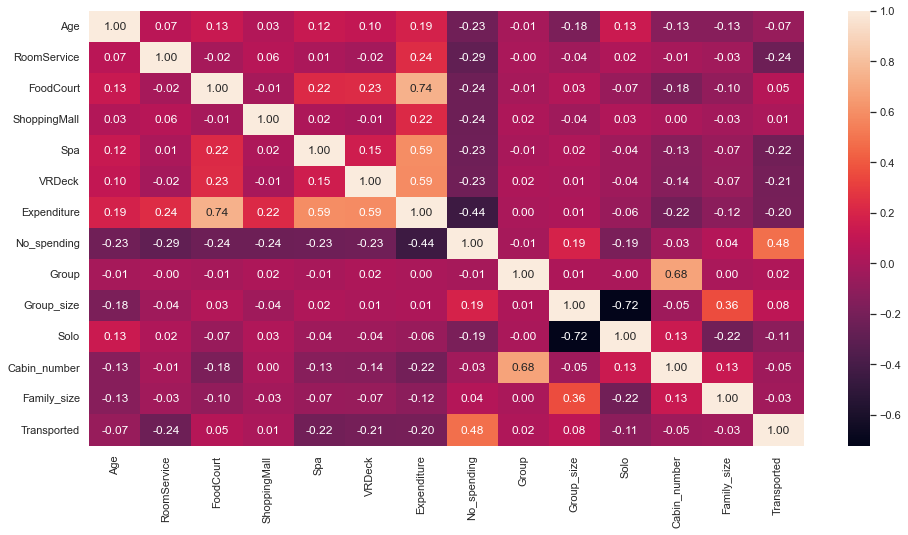

In [292]:
plt.figure(figsize=(16, 8))
sns.heatmap(pd.concat([X, train_df['Transported'].astype(int)], axis=1).corr(), annot=True, fmt='.2f')
plt.show()

- PassengerId, Group, Cabin number has too much cardianility and we have already extracted all the available information from it so we will remove them
- We can see that Group size and Solo has high cardianility so we will remove Group size from it as as Solo has much more realtion with Transported than Group size 

In [293]:
# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Cabin_number'], axis=1, inplace=True)

****Log transform****

The logarithm transform is used to decrease skew in distributions, especially with large outliers. It can make it easier for algorithms to 'learn' the correct relationships. We will apply it to the expenditure features as these are heavily skewed by outlier

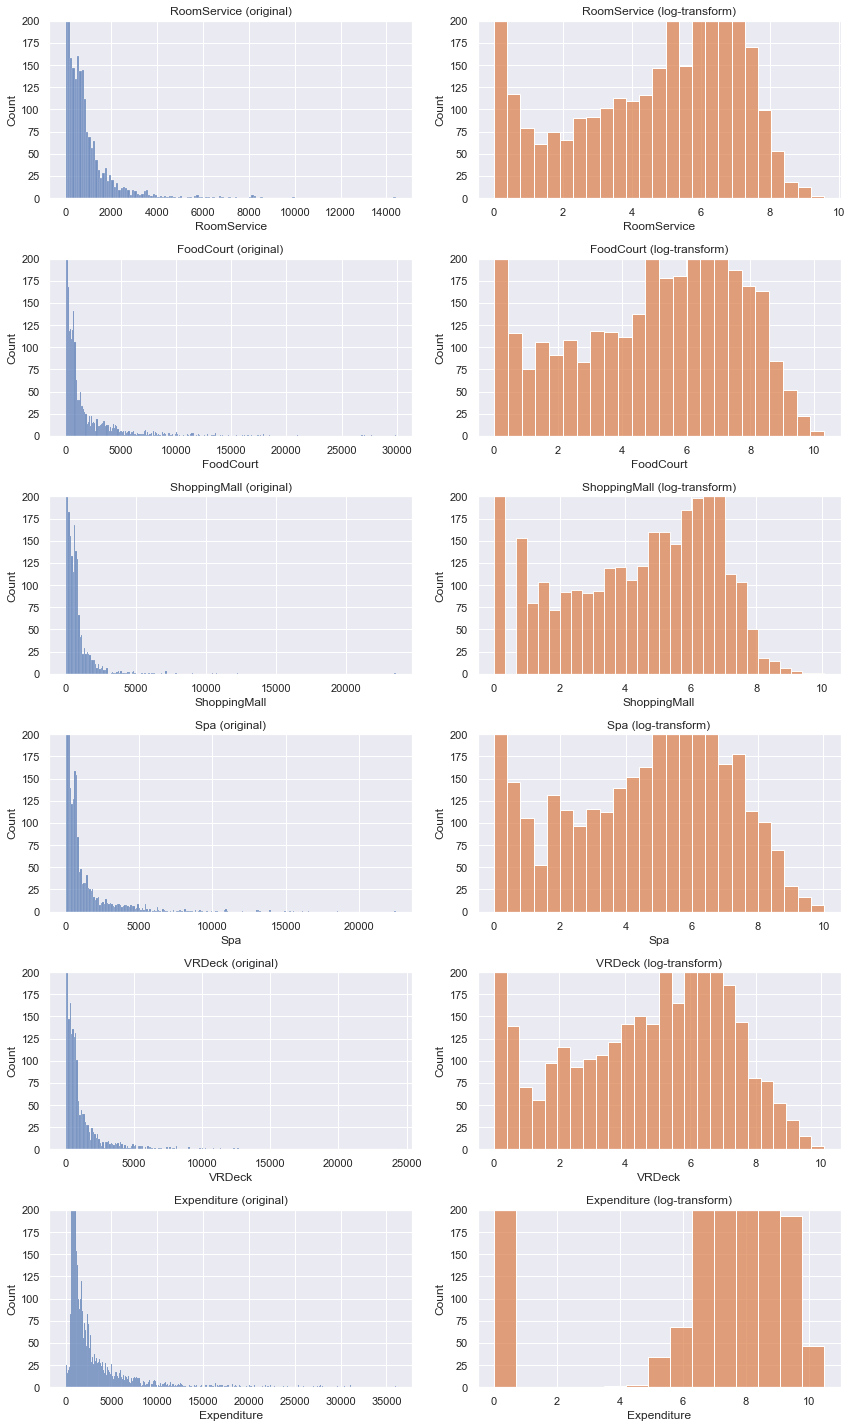

In [294]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
plt.tight_layout()

In [295]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

****Encoding and Scaling****

We will use column transformers to be more professional. It's also good practice.

In [296]:
i = X.loc[:, ['FoodCourt']]
s = StandardScaler()
s.fit_transform(i)

array([[-0.66798521],
       [ 0.11257932],
       [ 2.10576565],
       ...,
       [-0.66798521],
       [ 1.69024801],
       [ 2.19752982]])

In [297]:
std = i.std()
mean = i.mean()

(i-mean)/std

FoodCourt
0     -0.667947
1      0.112573
2      2.105645
3      1.758349
4      0.776997
...         ...
8688   2.324397
8689  -0.667947
8690  -0.667947
8691   1.690151
8692   2.197403

[8693 rows x 1 columns]

<h4>LATER WE WILL REMOVE CABIN REGION AND OTHER CATEGORICAL FEATURES ONE CATEGORY WHICH WE DID NOT DO BELOW SOME OTHER FEATURES LIKE VIP </h4>

In [298]:
X['Age_group'] = X['Age_group'].astype('object')
X_test['Age_group'] = X_test['Age_group'].astype('object')

X['Cabin_region'] = X['Cabin_region'].astype('object')
X_test['Cabin_region'] = X_test['Cabin_region'].astype('object')

****SOME INFO ABOUT DROPPING A CATEGORY IN ONE HOT ENCODING****<BR>
Specifies a methodology to use to drop one of the categories per
feature. This is useful in situations where perfectly collinear
features cause problems, such as when feeding the resulting data
into a neural network or an unregularized regression.

However, dropping one category breaks the symmetry of the original
representation and can therefore induce a bias in downstream models,
for instance for penalized linear classification or regression models.

In [299]:
numerical_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', 
                                                                 sparse=False))])

ct = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')


X = ct.fit_transform(x)
X_test = ct.transform(X_test)



# Print new shape
print('Training set shape:', X.shape)
print('Test set shape:', X_test.shape)

Training set shape: (8693, 42)
Test set shape: (4277, 42)


<h3>Spliting into validation and train set</h3>

* check for target ratio in train and validation dataset 
* see the features statistics and in train and test set to see if the dataset was evenly split

we would have done all fo this for test too if test set were not already given

In [300]:
# Train-validation split
y = y.astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y, test_size=0.18, random_state=0)

In [301]:
print(f"Train size {len(X_train)}")
print(f"Validation size {len(X_valid)}")

Train size 7128
Validation size 1565


****check for target feature ration****

It is already done because we have specifid stratify=y during spliting which would ensure that the target ratio were maintained during spliting

In [302]:
def check_target_ratio(df):
    df = df.to_frame()
    class_1, class_2 = df['Transported'].value_counts()
    return class_1/class_2

print(f"For train dataset the the target ratio is {check_target_ratio(y_train)}")
print(f"For validation dataset the the target ratio is {check_target_ratio(y_valid)}")

For train dataset the the target ratio is 1.0146975692481628
For validation dataset the the target ratio is 1.0141570141570142


Here we need to check that our train and validation features distribution are the same a quick way to do this is to check the mean and std of the features

In [303]:
temp_X_train = pd.DataFrame(X_train)
temp_X_valid = pd.DataFrame(X_valid)

print("For training set")
display(temp_X_train.describe())

print("For validation set")
display(temp_X_valid.describe())

For training set


0            1            2            3            4   \
count  7128.000000  7128.000000  7128.000000  7128.000000  7128.000000   
mean     -0.002990    -0.003709     0.004020     0.004960     0.001166   
std       0.999143     0.998829     1.001719     1.003378     1.000062   
min      -2.011485    -0.657046    -0.667985    -0.640844    -0.683889   
25%      -0.616643    -0.657046    -0.667985    -0.640844    -0.683889   
50%      -0.128449    -0.657046    -0.667985    -0.640844    -0.683889   
75%       0.568972     0.813298     0.845935     0.709705     0.863413   
max       3.498139     2.834747     2.824589     3.246618     2.906083   

                5            6            7            8            9   ...  \
count  7128.000000  7128.000000  7128.000000  7128.000000  7128.000000  ...   
mean      0.004098     0.006148    -0.004798    -0.001963     0.000079  ...   
std       1.003625     1.000479     0.999267     1.000276     1.004880  ...   
min      -0.658221    -1.159205    -0.848542    -1.111690    -1.823187  ...   
25%      -0.658221    -1.159205    -0.848542    -1.111690    -0.817053  ...   
50%      -0.658221     0.628607    -0.848542     0.899532    -0.146296  ...   
75%       0.798835     0.818671     1.178492     0.899532     0.524460  ...   
max       2.990542     1.681474     1.178492     0.899532     4.213620  ...   

                32           33           34           35           36  \
count  7128.000000  7128.000000  7128.000000  7128.000000  7128.000000   
mean      0.495090     0.498597     0.006313     0.422840     0.174944   
std       0.500011     0.500033     0.079210     0.494045     0.379946   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                37           38           39           40           41  
count  7128.000000  7128.000000  7128.000000  7128.000000  7128.000000  
mean      0.116723     0.113356     0.108446     0.054293     0.009400  
std       0.321112     0.317049     0.310964     0.226611     0.096501  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 42 columns]

For validation set


0            1            2            3            4   \
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000   
mean      0.013620     0.016894    -0.018312    -0.022593    -0.005308   
std       1.004419     1.005781     0.992568     0.984795     1.000340   
min      -2.011485    -0.657046    -0.667985    -0.640844    -0.683889   
25%      -0.616643    -0.657046    -0.667985    -0.640844    -0.683889   
50%      -0.128449    -0.657046    -0.667985    -0.640844    -0.683889   
75%       0.638714     0.898277     0.849809     0.617617     0.833531   
max       3.428397     2.647946     2.799951     2.740203     2.838796   

                5            6            7            8            9   ...  \
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000  ...   
mean     -0.018663    -0.028002     0.021852     0.008940    -0.000359  ...   
std       0.983746     0.997975     1.003681     0.999331     0.978106  ...   
min      -0.658221    -1.159205    -0.848542    -1.111690    -1.823187  ...   
25%      -0.658221    -1.159205    -0.848542    -1.111690    -0.817053  ...   
50%      -0.658221     0.619263    -0.848542     0.899532    -0.146296  ...   
75%       0.733886     0.782697     1.178492     0.899532     0.524460  ...   
max       2.750490     1.641729     1.178492     0.899532     4.213620  ...   

                32           33           34           35           36  \
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000   
mean      0.474760     0.520767     0.004473     0.408946     0.175080   
std       0.499522     0.499728     0.066751     0.491796     0.380157   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     1.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                37           38           39           40           41  
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000  
mean      0.111182     0.126518     0.118850     0.051118     0.008307  
std       0.314458     0.332538     0.323715     0.220309     0.090791  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 42 columns]

****We can see that the distribution are roughly equal but a better choice would have been to use unittest to check for std, mean and null and show error if std and null cross certain threshold or null exits****

<h3>Establishing a Baseline</h3>

We will establish a simple model and create a baseline and the a model to be successful it have to do better than the base line score

Here we wil assume that all of the passengers were transported and measure the accuracy

In [304]:
y_base_pred = np.ones(len(y_valid))

print(f"For baseline model accuracy: {accuracy_score(y_valid, y_base_pred)}")

For baseline model accuracy: 0.5035143769968051


<h3>Model selection¶</h3>
To briefly mention the algorithms we will use,


<b>Logistic Regression:</b> Unlike linear regression which uses Least Squares, this model uses Maximum Likelihood Estimation to fit a sigmoid-curve on the target variable distribution. The sigmoid/logistic curve is commonly used when the data is questions had binary output.

<b>K-Nearest Neighbors (KNN):</b> KNN works by selecting the majority class of the k-nearest neighbours, where the metric used is usually Euclidean distance. It is a simple and effective algorithm but can be sensitive by many factors, e.g. the value of k, the preprocessing done to the data and the metric used.

<b>Support Vector Machine (SVM):</b> SVM finds the optimal hyperplane that seperates the data in the feature space. Predictions are made by looking at which side of the hyperplane the test point lies on. Ordinary SVM assumes the data is linearly separable, which is not always the case. A kernel trick can be used when this assumption fails to transform the data into a higher dimensional space where it is linearly seperable. SVM is a popular algorithm because it is computationally effecient and produces very good results.

<b>Random Forest (RF):</b> RF is a reliable ensemble of decision trees, which can be used for regression or classification problems. Here, the individual trees are built via bagging (i.e. aggregation of bootstraps which are nothing but multiple train datasets created via sampling with replacement) and split using fewer features. The resulting diverse forest of uncorrelated trees exhibits reduced variance; therefore, is more robust towards change in data and carries its prediction accuracy to new data. It works well with both continuous & categorical data.

<b>Extreme Gradient Boosting (XGBoost):</b> XGBoost is similar to RF in that it is made up of an ensemble of decision-trees. The difference arises in how those trees as derived; XGboost uses extreme gradient boosting when optimising its objective function. It often produces the best results but is relatively slow compared to other gradient boosting algorithms.

<b>Light Gradient Boosting Machine (LGBM):</b> LGBM works essentially the same as XGBoost but with a lighter boosting technique. It usually produces similar results to XGBoost but is significantly faster.

<b>Categorical Boosting (CatBoost):</b> CatBoost is an open source algorithm based on gradient boosted decision trees. It supports numerical, categorical and text features. It works well with heterogeneous data and even relatively small data. Informally, it tries to take the best of both worlds from XGBoost and LGBM.

<b>Naive Bayes (NB):</b> Naive Bayes learns how to classify samples by using Bayes' Theorem. It uses prior information to 'update' the probability of an event by incoorporateing this information according to Bayes' law. The algorithm is quite fast but a downside is that it assumes the input features are independent, which is not always the case.

We will train these models and evaluate them on the validation set to then choose which ones to carry through to the next stage (cross validation).

<h3>Define classifiers


In [305]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
#     "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [1500, 1000, 500]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    #"XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

****Train and evaluate models****

Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.

In [306]:
i=0
clf_best_params=classifiers.copy()
valid_scores = pd.DataFrame({"Classifier": classifiers.keys(), "Validation accuracy": np.zeros(len(classifiers)),
                            "Training Time": np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    start = time.time()
    
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)
    clf.fit(X_train, y_train)
    
    valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)
    
    clf_best_params[key] = clf.best_params_
    
    stop = time.time()
    
    valid_scores.iloc[i, 2] = round(stop - start, 2)
    
    print('Model:', key)
    print('Training time (seconds):', valid_scores.iloc[i, 2])
    print('')
    i+=1

Model: LogisticRegression
Training time (seconds): 6.18

Model: KNN
Training time (seconds): 4.45

Model: SVC
Training time (seconds): 367.8

Model: RandomForest
Training time (seconds): 25.27

Model: LGBM
Training time (seconds): 7.32

Model: CatBoost
Training time (seconds): 407.07

Model: NaiveBayes
Training time (seconds): 0.31



In [307]:
# Show results
valid_scores

Classifier  Validation accuracy  Training Time
0  LogisticRegression             0.778275           6.18
1                 KNN             0.757188           4.45
2                 SVC             0.803195         367.80
3        RandomForest             0.797444          25.27
4                LGBM             0.808946           7.32
5            CatBoost             0.804473         407.07
6          NaiveBayes             0.737380           0.31

In [308]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 1, 'max_iter': 1500, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'SVC': {'C': 1.25, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 12, 'n_estimators': 250},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 100},
 'NaiveBayes': {'var_smoothing': 1e-07}}

****Define best models****

In [310]:
best_classifiers = {"LGBM": LGBMClassifier(**clf_best_params['LGBM'], random_state=0)
              ,"CatBoost": CatBoostClassifier(**clf_best_params['CatBoost'], verbose=False, random_state=0)
                   }

****Cross validation and ensembling predictions*****

Predictions are ensembled together using soft voting. This averages the predicted probabilies to produce the most confident predictions.

In [311]:
KFold = 10
preds = np.zeros(len(X_test))
y = y.reset_index(drop=True)

for key, classifier in best_classifiers.items():
    start = time.time()
    score = 0
    cv = StratifiedKFold(n_splits=KFold, shuffle=True, random_state=0)

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        clf = classifier
        clf.fit(X_train, y_train)
        
        score += clf.score(X_val, y_val)
        preds += clf.predict_proba(X_test)[:, 1]
        
#   average accuracy
    score = score / KFold
    
#     stop time
    end = time.time()
    
    
    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,3))
    print('Training time (mins):', round((stop - start)/60, 2))
    print('')
    
    
preds = preds / (KFold * len(best_classifiers))

Model: LGBM
Average validation accuracy: 81.307
Training time (mins): -3.4

Model: CatBoost
Average validation accuracy: 81.008
Training time (mins): -3.43



<h3>Submission</h3>
Let's look at the distribution of the predicted probabilities.

Text(0.5, 0, 'Probability')

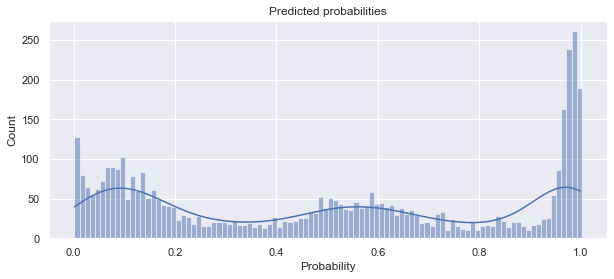

In [312]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')


It is interesting to see that the models are either very confident or very unconfident but not much in between.

<h3>Post processing</h3>

Finally, we need to convert each predicted probability into one of the two classes (transported or not). The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). However, assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportion of transported/not transported in our predictions as in the train set. Remember that the proportion of transported passengers in the train set was 50.4%.

In [318]:
np.round(np.round(100 * preds).sum()/len(preds), 2)

50.66

It seems that post processing is not necessary as the percentage of transported/not transported is very close

Text(0.5, 1.0, 'Prediction distribution')

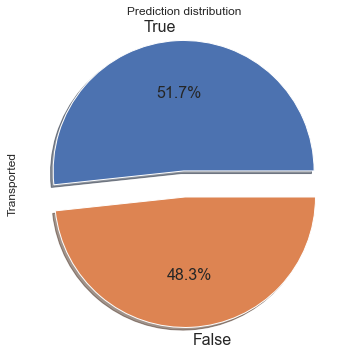

In [316]:
# Sample submission (to get right format)
sub=pd.read_csv(path / 'sample_submission.csv')

# Add predictions
sub['Transported']= np.round(preds)

# # Replace 0 to False and 1 to True
sub = sub.replace({0:False, 1:True})

# # Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [317]:
sub.to_csv(path / "cat_lightbgmc.csv", index=False)